# XGBoost for BACtrack Data

In [53]:
import os
import logging
import datetime as dt
import pandas as pd
import numpy as np
import h5py
import itertools
import sys

import pyarrow as pa
import pyarrow.parquet as pq

# Might need to go before xgboost imports
import importlib
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import xgboost as xgb
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, auc, roc_curve, \
    confusion_matrix, classification_report
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
%config Application.log_level="INFO"

In [54]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')

2019-06-07 16:01:00,114 | INFO : Hello world!


#### GLOBAL VARIABLES AND SETTINGS

In [55]:
# Secure-copy updated data to server: 
# scp $LOCAL_PATH kaschbacher@tisoncluster.ucsf.edu:$SERVER_PATH

In [62]:
DATA_FOLDER = 'data'
FIGURE_FOLDER = 'figures'
#FILENAME = 'bac_2018-11-27.h5'
FILENAME = 'bac_2019-06-07.parquet'#'bac_2019-03-26.parquet'
PATH = '/'.join([DATA_FOLDER, FILENAME])
TODAY = str(dt.date.today())
MISSING_VALUE = np.nan

In [63]:
SEED = 9
TRAIN_P = .70
DEV_P = .10

TEST_P = 1 - TRAIN_P - DEV_P
split_percents = [TRAIN_P, DEV_P, TEST_P]

In [64]:
DEFAULT_BOOSTING_PARAMS = {
    'silent':1,
    'learning_rate':.3,
    'max_depth':6,
    'min_child_weight':1,# default=1, larger=more conservative; building process will give up partitioning 
    'subsample':0.80,
    'colsample_bytree':0.80,
    'objective':'binary:logistic',#'objective':'binary:logistic' or 'reg:linear'
    'num_boost_round': 10,
    #'eval_metric':'auc',
    'random_state':7,
    'lambda':1,# default=1, L2 (ridge); higher values = more conservative
    'alpha':0,# default=0, L1 (lasso); higher values = more conservative
    'gamma':0,# [default=0, alias: min_split_loss] - Larger=more conservative. Minimum loss reduction required to make a further partition on a leaf node of the tree
    'scale_pos_weight':1# default=1, reset later based on class distribution
}

In [65]:
# Starts with defaults, but can change
boosting_params = DEFAULT_BOOSTING_PARAMS

In [66]:
# Set Parameters for Grid Search
def get_gs_params(params):
    gs_params = {
        'learning_rate': params['learning_rate'], 
        'num_boost_round': params['num_boost_round'],
        #'n_estimators': best_n_estimators, 
        'max_depth': params['max_depth'],
        'min_child_weight': params['min_child_weight'], 
        'gamma': params['gamma'], 
        'subsample': params['subsample'], 
        'colsample_bytree': params['colsample_bytree'], 
        'return_train_score': True,
        'objective': 'binary:logistic', 
        #'n_jobs': 4,# -1 --> make use of all the cores in your system; but supposedly could also slow things 
        'scale_pos_weight':params['scale_pos_weight'], 
        'seed':7
    }
    return gs_params

In [67]:
figure_params = {
    'figure.figsize':(5,5),
    'figure.titlesize':20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'axes.labelsize': 18
}

#### Load Data

In [68]:
%%time

def load_data(path):
    
    df = pq.read_table(path, use_threads=4).to_pandas()
    names = df.columns.tolist()
    data = df.values
    
    return names, data

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 16.9 µs


#### Randomly Shuffle the rows
--- so that there is no systematic association of date with train/val/test

In [69]:
def shuffle_rows(data, SEED):
    # shuffles rows of an np-array, w/ seed, order will always be replicable
    np.random.seed(seed=SEED)
    np.random.shuffle(data)
    return data

#### Split train/dev/test set 70-10-20

In [70]:
def partition_dataset(split_percents, data):
    train_per, dev_per, test_per = split_percents
    m = data.shape[0]
    train, dev, test = np.split(data, [int(m*train_per), int(m*(train_per+dev_per))]) 
    print ('train shape: {}, dev shape: {}, test shape: {}'.format(train.shape, dev.shape, test.shape))
    assert train.shape[0] + dev.shape[0] + test.shape[0] == data.shape[0]
    
    # Assumes y or target outcome is the first column, and that all other columns will be included in X
    partitions = {}
    partitions['X_train'] = train[:,1:]
    partitions['y_train'] = train[:,0]
    partitions['X_dev'] = dev[:,1:]
    partitions['y_dev'] = dev[:,0]
    partitions['X_test'] = test[:,1:]
    partitions['y_test'] = test[:,0]
    
    return partitions

#### Package Data Matrices for XGBoost

In [71]:
def package_data (partitions, names):
    # Assign data - (Note: must dropna first, otherwise missing=-999 throws an error because NaNs also still exist)
    print ("\nSetting up data-matrices for Gradient Boosted Classification Tree with Outcome: {}...\n".format(names[0]))

    names = [str(name) for name in names]# convert from byte to string
    partitions['names']=names
    partitions['dtrain'] = xgb.DMatrix(data=partitions['X_train'], label=partitions['y_train'], 
                                       feature_names=names[1:], missing=MISSING_VALUE)
    partitions['ddev'] = xgb.DMatrix(data=partitions['X_dev'], label=partitions['y_dev'], 
                                     feature_names=names[1:], missing=MISSING_VALUE)
    partitions['dtest'] = xgb.DMatrix(data=partitions['X_test'], label=partitions['y_test'], 
                                      feature_names=names[1:], missing=MISSING_VALUE)
    
    return partitions

#### Balance Classes

In [72]:
def get_balance_weight(y_train):

    pos = np.sum(y_train, axis=0, dtype=int)
    neg = y_train.shape[0]-pos
    print ('\n{} positive cases and {} negative cases'.format(pos, neg))

    scale_pos_weight = round(neg/pos, 2)# 2.38 for the BACtrack dataset
    print ('Scale Weight for balanced classes would be: {}'.format(scale_pos_weight))
    return scale_pos_weight

#### Training/Fitting the Model
--- fit vs train -- https://datascience.stackexchange.com/questions/17282/xgbregressor-vs-xgboost-train-huge-speed-difference

In [73]:
def fit_model(dtrain, ddev, boosting_params):
    # # Training a Model
    # # -- xgboost.train will ignore parameter n_estimators, while xgboost.XGBRegressor accepts. 
    # # -- In xgboost.train, boosting iterations (i.e. n_estimators) is controlled by num_boost_round(default: 10)
    # # -- the learning_rate (eta) and num_boost_rounds are instrisincally connected.  
    # # -- Slower learning rates will typically require more rounds

    # if num_boost_round not explicitly given as kwarg, it will be overridden by default of 10, which can be seen in eval printing
    watchlist = [(ddev, 'dev'), (dtrain, 'train')]
    %time
    model = xgb.train(params=boosting_params, dtrain=dtrain, evals=watchlist, verbose_eval=True,
                      num_boost_round=boosting_params['num_boost_round'])# try predictor='gpu_predictor'
    return model

#### Make & Evaluate Model Predictions

In [74]:
def predict(model, d_true):
    # d_true is the xgboost prepared dataset corresponding to test or dev (per needs); includes X and y and names
    y_proba = model.predict(d_true)
    y_pred = [round(value) for value in y_proba]# Use to get 0 vs 1?
    return y_pred, y_proba

In [75]:
def evaluate_model(y_true, y_pred, y_proba):
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba, average='micro', max_fpr=None)#sample_weight=scale_pos_weight, 
    print ('Accuracy: {:02.2f}%'.format(accuracy*100.))
    print ('ROC AUC: {:02.2f}%'.format(roc_auc*100.))
    return accuracy, roc_auc

#### Confusion Matrix

In [76]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix\n")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

#### Full Report (w/ Confusion Matrix)

In [77]:
def full_report(figure_params, y_test, y_pred, target_names):
    
    # # Plot Confusion Matrix for Classification - http://scikit-learn.org/stable/modules/model_evaluation.html
    plt.rcParams.update(figure_params)

    cnf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    fig = plt.figure()
    plot_confusion_matrix(cnf_matrix, ['low BAC','high BAC'], normalize=True)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()
    fig.savefig('/'.join( \
        [FIGURE_FOLDER,'/cm/Normalized_Confusion_Matrix_BAC_Classification_{}.png'.format(TODAY)]), \
        bbox_inches='tight')

    # Classification Report
    #print ('\nAccuracy: {:02.2f}%\n'.format(accuracy*100.))
    print (classification_report(y_test, y_pred, target_names=target_names),'\n')

### Plot ROC

In [78]:
def plot_ROC(y_test, y_pred_proba):
    # y_test can also be y_dev, depending on context
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calculate x and y for ROC-curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    #print (fpr.shape, tpr.shape, roc_auc)# DEBUG

    #Plot of a ROC curve for a specific class
    plt.rcParams.update(figure_params)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

### Built-in Feature Importance Graph:  
--- importance_type='weight' matches above.  'cover' provides quite different results, which may be of interest to report in paper.

In [79]:
def graph_importances(model):  
    
    # -- http://xgboost.readthedocs.io/en/latest/python/python_api.html
    # weight” is the number of times a feature appears in a tree “gain” is the average gain of splits which use the feature...
    # “cover” is the average coverage of splits which use the feature, where coverage is defined as the number of samples affected by the split
    plt.rcParams['figure.figsize']=(14,18)
    xgb.plot_importance(model, importance_type='weight')
    plt.title('Feature Importance (Weight)', fontsize=20)
    plt.show()
    plt.savefig('/'.join([FIGURE_FOLDER,'fi/feature_importance_{}.png'.format(TODAY)]), \
                bbox_inches='tight')   

### MAIN

In [82]:
%%time
# Load Data
names, data = load_data(PATH)
print (data.shape, '\n')# QA
print (names[:3])# Ensure that bac_clinical (or the outcome) is the first column!

(973264, 92) 

['bac_clinical', 'user_id', 'bac_guess']
CPU times: user 3.74 s, sys: 2.07 s, total: 5.81 s
Wall time: 2.88 s


In [95]:
# Find number of unique users
data_df = pd.DataFrame(data, columns=names)
vc = data_df.user_id.value_counts()# series with user_id and count of observations per user
print ('Number of unique users: {}'.format(data_df.user_id.unique().shape[0]))

Number of unique users: 33460


#### Prepare Data

In [38]:
%%time
# Partition randomly
shuffle_rows(data, SEED)
partitions = partition_dataset(split_percents, data)

# Package data for XGboost
partitions = package_data(partitions, names)# Adds names + dtrain, ddev, dtest

train shape: (681284, 91), dev shape: (97327, 91), test shape: (194653, 91)

Setting up data-matrices for Gradient Boosted Classification Tree with Outcome: bac_clinical...

CPU times: user 5.61 s, sys: 1.13 s, total: 6.75 s
Wall time: 7.07 s


### Balancing the Classes/ Determining Class Weights

In [39]:
def balance_classes(boosting_params, partitions):
    prior_scale_pos_weight = boosting_params['scale_pos_weight']
    # Reset scale weight in boosting params and in the grid search params both
    boosting_params['scale_pos_weight'] = get_balance_weight(partitions['y_train'])
    gs_params = get_gs_params(boosting_params)
    print ('\nResetting positive scale weight from {} to {}...\n'.format(prior_scale_pos_weight, boosting_params['scale_pos_weight']))
    return gs_params

## Default Model for Comparison

In [40]:
def base_model_wwo_balancing(boosting_params, partitions):
    
    # Assumption is that boosting_params starts out at the default, and then can be altered throughout the tuning process
    if boosting_params != DEFAULT_BOOSTING_PARAMS:
        print ('Resetting boosting params to be equal to DEFAULT\n')
        boosting_params = DEFAULT_BOOSTING_PARAMS
    # Assumes we start with no scale weighting, and compare that to weighting inversely to case prevalence in the training set
    if boosting_params['scale_pos_weight'] != 1:
        print ('Converting the scale weight for boosting params back to 1 for the first run...\n')
        boosting_params['scale_pos_weight'] = 1
    
    # Fit & Evaluate model twice: 1) Unbalanced, 2) Balanced
    for i in range(0,2):
        if i>0: 
            print ('-'*60,'\n')
            balance_classes(boosting_params, partitions)
            
        # Fit Model
        print ('Run {}, Scale weight = {:0.2f}'.format(i, boosting_params['scale_pos_weight']))
        model= fit_model(partitions['dtrain'], partitions['ddev'], boosting_params)

        # Predict/ Evaluate in Dev set
        y_true = partitions['y_dev']; d_true = partitions['ddev']
        y_pred, y_proba = predict(model, d_true)
        accuracy, roc = evaluate_model(y_true, y_pred, y_proba)

        # Get Results & Figures
        plot_ROC(y_true, y_proba)
        full_report(figure_params, y_true, y_pred, ['bac <.08', 'bac >=.08'])
        #graph_importances(model) 
        
#base_model_wwo_balancing(boosting_params, partitions)   

### Use Cross-Validated XGBoost to determine the optimal number of trees

In [46]:
%%time

# EVALUATE LEARNING RATE AND MAX_DEPTH TOGETHER
# For learning_rate=1 & max_depth=6 --> optimal number of trees=30
boosting_params['learning_rate']= .01
boosting_params['max_depth']= 6
boosting_params['nthread']=-1
boosting_params['num_boost_round']= 500
boosting_params['verbose']=2
# watchlist = [(partitions['ddev'], 'dev'), (partitions['dtrain'], 'train')]
# boosting_params['evals']=watchlist

print ('Boosting Params...\n')
for k, p in boosting_params.items():
    print (k,p)
print ('\n')

cvresult = xgb.cv(boosting_params, partitions['dtrain'], num_boost_round=boosting_params['num_boost_round'], \
                 nfold=3, early_stopping_rounds=10, verbose_eval=True, \
                 seed=7, metrics='auc')# metrics=['auc','mae','map']

best_n_estimators = cvresult.shape[0]
print ('\nThe optimal number of trees is {}\n'.format(best_n_estimators))
# optimal trees was 52 with learning rate of 1 and early_stopping=10

Boosting Params...

silent 1
learning_rate 0.01
max_depth 6
min_child_weight 1
subsample 0.8
colsample_bytree 0.8
objective binary:logistic
num_boost_round 500
random_state 7
lambda 1
alpha 0
gamma 0
scale_pos_weight 2.38
nthread -1
verbose 2
evals None


[0]	train-auc:0.829463+0.00239069	test-auc:0.828592+0.00291422
[1]	train-auc:0.853151+0.00120702	test-auc:0.852432+0.00192438
[2]	train-auc:0.851196+0.001202	test-auc:0.850477+0.00101354
[3]	train-auc:0.856012+0.000973725	test-auc:0.855274+0.00083944
[4]	train-auc:0.856553+0.00117859	test-auc:0.855704+0.0012035
[5]	train-auc:0.857687+0.000576852	test-auc:0.856853+0.000404544
[6]	train-auc:0.857785+0.0015244	test-auc:0.856984+0.00107422
[7]	train-auc:0.858662+0.00111942	test-auc:0.857876+0.000669942
[8]	train-auc:0.858788+0.00148692	test-auc:0.857972+0.00107597
[9]	train-auc:0.859533+0.000762019	test-auc:0.858669+0.000536616
[10]	train-auc:0.859784+0.00062195	test-auc:0.858918+6.68331e-05
[11]	train-auc:0.860117+0.000452124	test-auc:0.

[122]	train-auc:0.864134+0.000273324	test-auc:0.86308+0.000552813
[123]	train-auc:0.864166+0.000273147	test-auc:0.863109+0.000548691
[124]	train-auc:0.864182+0.000285368	test-auc:0.863122+0.00053942
[125]	train-auc:0.864216+0.000291627	test-auc:0.86315+0.000518119
[126]	train-auc:0.864269+0.000282807	test-auc:0.8632+0.000515252
[127]	train-auc:0.86431+0.000284868	test-auc:0.863239+0.000506882
[128]	train-auc:0.864328+0.000277359	test-auc:0.863257+0.000505781
[129]	train-auc:0.864351+0.000276552	test-auc:0.863278+0.000514756
[130]	train-auc:0.864381+0.000287136	test-auc:0.863306+0.000503618
[131]	train-auc:0.864432+0.00030254	test-auc:0.863352+0.000489661
[132]	train-auc:0.864457+0.000295658	test-auc:0.863378+0.000484981
[133]	train-auc:0.864499+0.000317864	test-auc:0.863417+0.000462085
[134]	train-auc:0.864516+0.00031248	test-auc:0.863431+0.000460813
[135]	train-auc:0.864544+0.000303481	test-auc:0.863457+0.000462369
[136]	train-auc:0.864591+0.000328423	test-auc:0.8635+0.000451407
[137]

KeyboardInterrupt: 

In [47]:
best_idx = np.where(cvresult.iloc[:,2]==cvresult.iloc[:,2].max())[0][0]
print ('Best AUC in test set: {:0.4f} with {} trees or n_estimators'.format(cvresult.iloc[best_idx,2], best_idx+1))

NameError: name 'cvresult' is not defined

### Reset the number of Estimators (Trees) to match CV outcome

In [ ]:
boosting_params['num_boost_round']=best_n_estimators
gs_params['num_boost_round']=best_n_estimators

print (boosting_params)
today = dt.date.today()
print (today)

# Grid Search

In [ ]:
# %%time

param_test1 = {
 'max_depth': list(np.arange(5, 8, 1)),
 'min_child_weight': list(np.arange(1, 21, 10))#[ 1  6 11 16 21]
}# 'alpha': [0, 1, 3]

boosting_params['learning_rate']= .3
boosting_params['num_boost_round']= 80
boosting_params['pos_scale_weight']= get_balance_weight(partitions['y_train'])

# Prints out in tmux terminal (not sure why...)
gs_params = get_gs_params(boosting_params)
print ('\n\nGrid Search parameters...\n','-'*20,'\n')
for k, gsp in gs_params.items():
    print (k, gsp)
print ('\n\n')
print (param_test1)

In [ ]:
%%time

# # Send logging to a file
today = dt.date.today()
#sys.stdout = open('xgboost_output_{}.txt'.format(today), 'w')

# May get an Unpickling Error/ Broken Process if using custom score with multiprocessing/n_jobs # scoring='roc_auc', 
gsearch1 = GridSearchCV(estimator = XGBClassifier(gs_params), \
                        param_grid = param_test1, \
                       verbose=3, \
                        n_jobs=1, iid=False, cv=3, refit=True)#return_train_score=True,

In [ ]:
%env LOKY_PICKLER='cloudpickle' 
import multiprocessing
#multiprocessing.set_start_method('forkserver', force=True)

try:
    multiprocessing.set_start_method('spawn')
except RuntimeError:
    pass

In [ ]:
gsearch1.fit(partitions['X_train'], partitions['y_train'], eval_metric='auc', verbose=True, \
            eval_set=[(partitions['X_dev'], partitions['y_dev'])], early_stopping_rounds=10)
# # Logging output to file
#sys.stdout = sys.__stdout__

In [ ]:
# PRINT BEST VALUES
# Note: The best score from GridSearchCV is biased. :( If you gridsearch best params, you will overfit in terms of AUC
print ('Best Hyperparameters: ', gsearch1.best_params_)
print ('Best Score: {:02f}'.format(gsearch1.best_score_))
print ('Best Estimator: ',gsearch1.best_estimator_)

### Reset Parameters to Best Values (from GridSearch)

In [ ]:
new_params = list(gsearch1.best_params_.keys())
for k, v in gsearch1.best_params_.items():
    print (k,v)
    boosting_params[k]=v  

In [ ]:
print (boosting_params)
print (DEFAULT_BOOSTING_PARAMS)

In [ ]:
#pd.DataFrame(gsearch1.cv_results_).head(3)

### Add Regularization

In [ ]:
# boosting_params['alpha']=1
# boosting_params['lambda']=10
# print (boosting_params)

# RUN FINAL MODEL

In [28]:
# Fit Model - evaluates in the test set
boosting_params['learning_rate']= .03
boosting_params['max_depth']=8
boosting_params['nthread']=-1
boosting_params['num_boost_round']= 500
boosting_params['verbose']=2
balance_classes(boosting_params, partitions)


print ('Boosting Params...\n')
for k, p in boosting_params.items():
    print (k,p)
print ('\n')

# error readout corresponds to 1-accuracy
model= fit_model(partitions['dtrain'], partitions['ddev'], boosting_params)
print ('\n', boosting_params)


201528 positive cases and 479756 negative cases
Scale Weight for balanced classes would be: 2.38

Resetting positive scale weight from 2.38 to 2.38...

Boosting Params...

silent 1
learning_rate 0.03
max_depth 8
min_child_weight 1
subsample 0.8
colsample_bytree 0.8
objective binary:logistic
num_boost_round 500
random_state 7
lambda 1
alpha 0
gamma 0
scale_pos_weight 2.38
nthread -1
verbose 2
evals None


[0]	dev-error:0.259815	train-error:0.259062
[1]	dev-error:0.249006	train-error:0.248864
[2]	dev-error:0.251359	train-error:0.251377
[3]	dev-error:0.257719	train-error:0.257004
[4]	dev-error:0.253958	train-error:0.253599
[5]	dev-error:0.249047	train-error:0.248516
[6]	dev-error:0.249129	train-error:0.248181
[7]	dev-error:0.2488	train-error:0.247947
[8]	dev-error:0.249191	train-error:0.248585
[9]	dev-error:0.249314	train-error:0.248645
[10]	dev-error:0.25028	train-error:0.249257
[11]	dev-error:0.249602	train-error:0.248585
[12]	dev-error:0.249294	train-error:0.248372
[13]	dev-error:0.24

[173]	dev-error:0.23605	train-error:0.231379
[174]	dev-error:0.236091	train-error:0.231299
[175]	dev-error:0.236101	train-error:0.23114
[176]	dev-error:0.23605	train-error:0.231092
[177]	dev-error:0.236039	train-error:0.230979
[178]	dev-error:0.235885	train-error:0.230876
[179]	dev-error:0.235906	train-error:0.230783
[180]	dev-error:0.235782	train-error:0.230644
[181]	dev-error:0.235608	train-error:0.230528
[182]	dev-error:0.235556	train-error:0.230431
[183]	dev-error:0.235526	train-error:0.230362
[184]	dev-error:0.235536	train-error:0.230271
[185]	dev-error:0.2353	train-error:0.230143
[186]	dev-error:0.2353	train-error:0.230082
[187]	dev-error:0.23532	train-error:0.229995
[188]	dev-error:0.235279	train-error:0.229881
[189]	dev-error:0.235351	train-error:0.229782
[190]	dev-error:0.235269	train-error:0.229669
[191]	dev-error:0.235176	train-error:0.229605
[192]	dev-error:0.235145	train-error:0.229543
[193]	dev-error:0.235043	train-error:0.229386
[194]	dev-error:0.23493	train-error:0.2292

[353]	dev-error:0.22894	train-error:0.217768
[354]	dev-error:0.22896	train-error:0.217758
[355]	dev-error:0.228847	train-error:0.217683
[356]	dev-error:0.228837	train-error:0.217608
[357]	dev-error:0.228734	train-error:0.217572
[358]	dev-error:0.228755	train-error:0.2175
[359]	dev-error:0.228868	train-error:0.217398
[360]	dev-error:0.228816	train-error:0.217388
[361]	dev-error:0.228744	train-error:0.21731
[362]	dev-error:0.228683	train-error:0.217194
[363]	dev-error:0.228652	train-error:0.217153
[364]	dev-error:0.22857	train-error:0.217099
[365]	dev-error:0.228559	train-error:0.217017
[366]	dev-error:0.22857	train-error:0.216986
[367]	dev-error:0.22858	train-error:0.216987
[368]	dev-error:0.22858	train-error:0.21693
[369]	dev-error:0.228539	train-error:0.216908
[370]	dev-error:0.228621	train-error:0.216843
[371]	dev-error:0.2286	train-error:0.216816
[372]	dev-error:0.22859	train-error:0.216722
[373]	dev-error:0.228446	train-error:0.216695
[374]	dev-error:0.228405	train-error:0.216663
[

Accuracy: 77.43%
ROC AUC: 88.16%
Normalized confusion matrix

[[0.74637491 0.25362509]
 [0.15927927 0.84072073]]


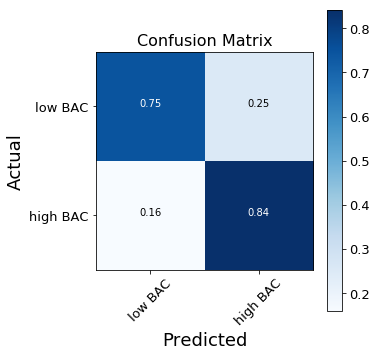

              precision    recall  f1-score   support

    bac <.08       0.92      0.75      0.82    137100
   bac >=.08       0.58      0.84      0.69     57553

   micro avg       0.77      0.77      0.77    194653
   macro avg       0.75      0.79      0.76    194653
weighted avg       0.82      0.77      0.78    194653
 



In [30]:
# Make Predictions in the TEST set
y_pred, y_proba = predict(model, partitions['dtest'])
accuracy, roc_auc = evaluate_model(partitions['y_test'], y_pred, y_proba)

# Plot Confusion Matrix
target_names = ['bac <.08', 'bac >=.08']
full_report(figure_params, partitions['y_test'], y_pred, target_names)

### ROC-AUC
--- https://www.kaggle.com/jeremy123w/xgboost-with-roc-curve
--- # # http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

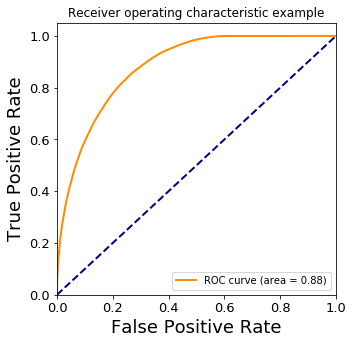

In [33]:
plot_ROC(partitions['y_test'], y_proba)

## Feature Importances

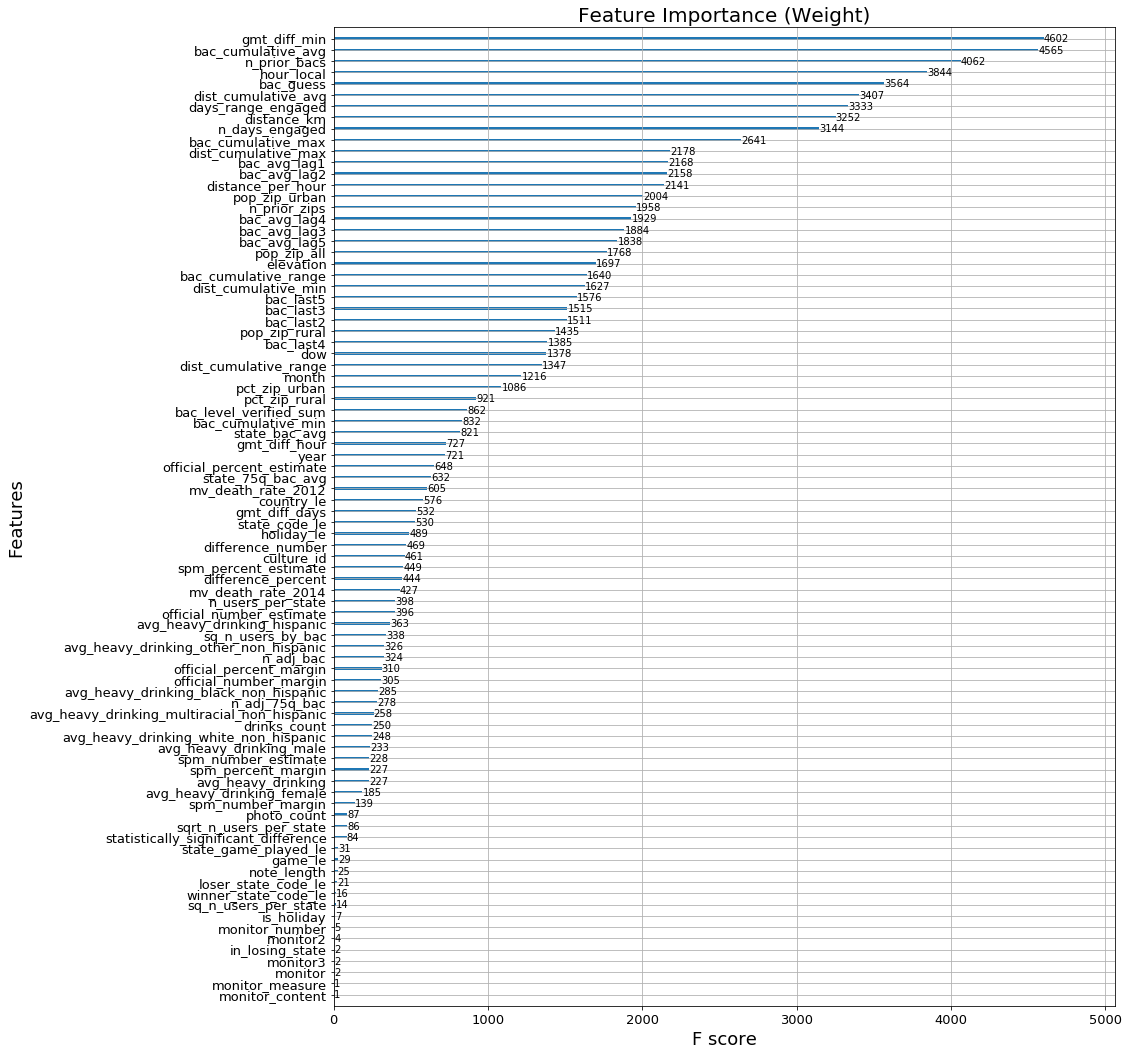

<Figure size 1008x1296 with 0 Axes>

In [43]:
graph_importances(model) 

# Save MODEL object - pickle

In [45]:
import pickle
pickle.dump(model, open("bac_final.pickle.dat", "wb"))

In [ ]:
print (DEFAULT_BOOSTING_PARAMS)
print (boosting_params)

In [ ]:
# ### Try to save to Kirstin's local

# LOCAL_FIGURE_FOLDER = '/Users/KAschbacher/Desktop/eheart/analysis/BAC/figures/server'
# plt.savefig('/'.join([LOCAL_FIGURE_FOLDER,'feature_importance_{}.png'.format(TODAY)]), \
#             bbox_inches='tight')